In [6]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_ollama import OllamaEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

KeyboardInterrupt: 

In [8]:
OllamaEmbeddings(model="llama3.2:3b")

OllamaEmbeddings(model='llama3.2:3b', base_url=None, client_kwargs={})

In [7]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OllamaEmbeddings(model="llama3.2:3b"),
)
retriever = vectorstore.as_retriever()

NameError: name 'docs_list' is not defined

In [3]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

tools = [retriever_tool]

In [4]:
from langchain_ollama import ChatOllama

In [5]:
llm = ChatOllama(temperature=0, model="llama3.2:1b")
llm_with_tool = llm.bind_tools(tools)

In [6]:
from typing import Literal

from langchain import hub
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel, Field

In [7]:
### Edges
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOllama(temperature=0, model="llama3.2:1b")

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


In [4]:
### Nodes
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOllama(temperature=0, model="llama3.2:1b")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


In [5]:
test_agent = agent({"messages": [HumanMessage(content="Who is Lilian Weng?")]})
print(test_agent)

NameError: name 'HumanMessage' is not defined

In [10]:
from langchain_core.prompts import ChatPromptTemplate

doc = """ \n
    Look at the input and try to reason about the underlying semantic intent / meaning. \n
    Here is the initial question:
    \n ------- \n
    {question}
    \n ------- \n
Formulate an improved question: """
prompt_temp = ChatPromptTemplate.from_template(doc)

In [11]:
prompt_temp.invoke({"question": "What is the OmniPred?"})

ChatPromptValue(messages=[HumanMessage(content=' \n\n    Look at the input and try to reason about the underlying semantic intent / meaning. \n\n    Here is the initial question:\n    \n ------- \n\n    What is the OmniPred?\n    \n ------- \n\nFormulate an improved question: ', additional_kwargs={}, response_metadata={})])

In [12]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n
    Look at the input and try to reason about the underlying semantic intent / meaning. \n
    Here is the initial question:
    \n ------- \n
    {question}
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = prompt_temp | ChatOllama(temperature=0, model="llama3.2:1b")
    response = model.invoke(question)
    return {"messages": [response]}

In [13]:
test_rewrite = rewrite({"messages": [HumanMessage(content="What is the OmniPred?")]})
print(test_rewrite)

---TRANSFORM QUERY---
{'messages': [AIMessage(content='Based on the context, I\'m going to take a guess that "OmniPred" refers to a type of predator or hunter in various mythologies and cultures. With that in mind, here\'s an improved question:\n\n"What is the concept of the OmniPred?"\n\nThis question still conveys the idea of something being a universal or omnipresent predator, but it\'s more concise and focused on the underlying semantic intent.', additional_kwargs={}, response_metadata={'model': 'llama3.2:1b', 'created_at': '2025-01-09T11:12:15.652250955Z', 'done': True, 'done_reason': 'stop', 'total_duration': 441614255, 'load_duration': 9150811, 'prompt_eval_count': 71, 'prompt_eval_duration': 1000000, 'eval_count': 84, 'eval_duration': 430000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-ae60fdcf-b9a3-4468-bca2-905c98101d1e-0', usage_metadata={'input_tokens': 71, 'output_tokens': 84, 'total_tokens': 155})]}


In [14]:
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOllama(temperature=0, model="llama3.2:1b")

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


In [15]:
from langgraph.prebuilt.chat_agent_executor import AgentState
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

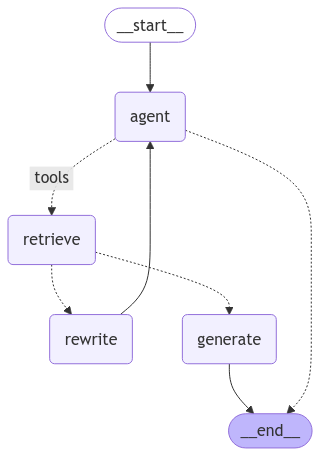

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [17]:
inputs = {
    "messages": [
        ("user", "Hello"),
    ]
}
output = graph.invoke(inputs)

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


/home/alexander/anaconda3/envs/LANGCHAIN/lib/python3.11/site-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [18]:
import pprint

inputs = {
    "messages": [
        ("user", "What is the OmniPred?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2:1b', 'created_at': '2025-01-09T11:13:37.658284942Z', 'done': True, 'done_reason': 'stop', 'total_duration': 145237617, 'load_duration': 9119316, 'prompt_eval_count': 187, 'prompt_eval_duration': 1000000, 'eval_count': 24, 'eval_duration': 133000000, 'message': Message(role='assistant', content='', images=None, tool_calls=None)}, id='run-4d7ad561-6658-450f-bda7-f85f3f2b1f66-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'OmniPred'}, 'id': 'e396535d-f2aa-4c1a-b384-2eb5ef9aadd1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 187, 'output_tokens': 24, 'total_tokens': 211})]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content="Nlp\nLanguage-Model\nAlignment\nSteerability\nPrompting\n\n\n\n« \n\nLLM Powered Autonomous Agents\n\n\n »\n\

/home/alexander/anaconda3/envs/LANGCHAIN/lib/python3.11/site-packages/langsmith/client.py:241: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


"Output from node 'generate':"
'---'
{ 'messages': [ 'The OmniPred is not explicitly mentioned in the provided '
                'context.']}
'\n---\n'
